In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
import os
from scipy.stats import pearsonr, linregress
import matplotlib.dates as mdates


In [2]:
# Set up ARTEMIS and OMNI raw file directories and list of files
projDir ='/Volumes/Research'
artemisDataDirectory = os.path.join(projDir, 'Solar-Wind-Reliability/output-data/GSE/Artemis/')
omniDataDirectory = os.path.join(projDir, 'Solar-Wind-Reliability/output-data/GSE/Omni/')
omniFileList = sorted(filter(lambda x: os.path.isfile(os.path.join(omniDataDirectory, x)), os.listdir(omniDataDirectory)))
artemisFileList = sorted(filter(lambda x: os.path.isfile(os.path.join(artemisDataDirectory, x)), os.listdir(artemisDataDirectory)))

omniFileList.remove('.DS_Store')
artemisFileList.remove('.DS_Store')

for nums, files in enumerate(omniFileList):
    print('{} - {}'.format(nums, files))

metricDirectory = os.path.join(projDir, 'Solar-Wind-Reliability/output-data/hourly-correlations/')
metricFolders = sorted(filter(lambda x: os.path.isdir(os.path.join(metricDirectory, x)), os.listdir(metricDirectory)))

0 - Omni_2011-10-24_18-10.csv
1 - Omni_2011-12-28_16-20.csv
2 - Omni_2013-01-17_10-30.csv
3 - Omni_2014-02-27_16-30.csv
4 - Omni_2014-02-27_18-30.csv
5 - Omni_2014-04-05_19-30.csv
6 - Omni_2015-03-16_03-50.csv
7 - Omni_2015-03-17_04-20.csv
8 - Omni_2015-04-20_20-10.csv
9 - Omni_2015-06-12_17-10.csv
10 - Omni_2016-06-05_05-00.csv
11 - Omni_2016-08-02_12-15.csv
12 - Omni_2017-09-15_12-00.csv
13 - Omni_2017-09-27_04-30.csv
14 - Omni_2018-09-13_00-00.csv
15 - Omni_2018-10-09_04-00.csv
16 - Omni_2019-11-27_13-00.csv


In [3]:
fta = 16

artemisData = pd.read_csv(os.path.join(artemisDataDirectory, artemisFileList[fta]), delimiter=',', header=0, index_col=0)
omniData = pd.read_csv(os.path.join(omniDataDirectory, omniFileList[fta]), delimiter=',', header=0, index_col=0)
artemisData['Time'] = pd.to_datetime(artemisData['Time'], format='%Y-%m-%d %H:%M:%S')
omniData['Time'] = pd.to_datetime(omniData['Time'], format='%Y-%m-%d %H:%M:%S')

In [4]:
def generate_axes(fig):
    gridspec = fig.add_gridspec(nrows=4, ncols=12)
    axes = {}
    axes['scatter'] = fig.add_subplot(gridspec[0:4, 0:4])
    axes['line'] = fig.add_subplot(gridspec[0:2, 4:8])
    axes['dots'] = fig.add_subplot(gridspec[2:4, 4:8])
    return axes

/var/folders/qq/kxsxv0ks5j16hqtn13mpk4sw0000gn/T/ipykernel_7827/4100090713.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


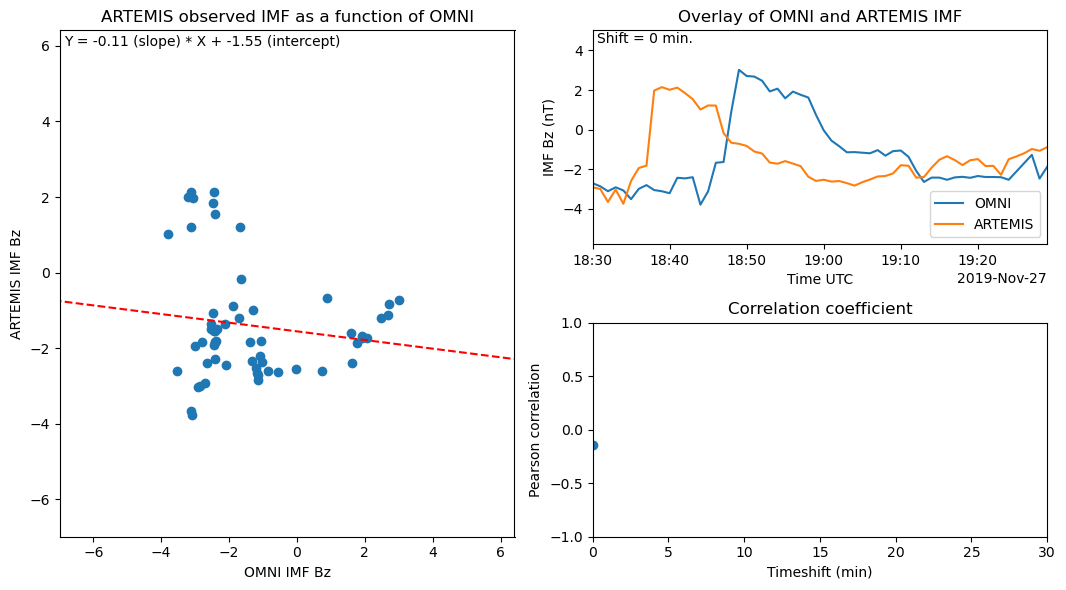

In [5]:
fig = plt.figure(figsize=(16, 6), constrained_layout=True)
axes = generate_axes(fig)

startValue = 300
aStart = (artemisData.loc[artemisData['Time'] == omniData['Time'][startValue]]).index[0]
aStop = (artemisData.loc[artemisData['Time'] == omniData['Time'][startValue+60]]).index[0]

minOffsets = np.arange(0,31,1)
pcc = []
aline = []
slopes = []
intercepts = []

for i in range(31):
    pcc.append(pearsonr(omniData['BZ_GSE'][startValue:startValue+60], artemisData['BZ_GSE'][aStart-i:aStop-i])[0])
    aline.append(artemisData['BZ_GSE'][aStart-i:aStop-i])
    slope, intercept, rvalue, pvalue, stderr = linregress(omniData['BZ_GSE'][startValue:startValue+60], artemisData['BZ_GSE'][aStart-i:aStop-i])
    slopes.append(slope)
    intercepts.append(intercept)

scat = axes['dots'].scatter(minOffsets[0], pcc[0])
fixed_line = axes['line'].plot(omniData['Time'][startValue:startValue+60], omniData['BZ_GSE'][startValue: startValue+60], label='OMNI')
line, = axes['line'].plot(np.arange(0,60,1), aline[0], label='ARTEMIS')
AvsO = axes['scatter'].scatter(omniData['BZ_GSE'][startValue: startValue+60], artemisData['BZ_GSE'][aStart: aStop])
slopeline, = axes['scatter'].plot(np.arange(-50,51,1), (intercepts[0]+(slopes[0]*np.arange(-50,51,1))), color='red', linestyle='dashed')

slopeText = axes['scatter'].text(.01, .99, '', ha='left', va='top', transform=axes['scatter'].transAxes)
shiftText = axes['line'].text(.01, .99, '', ha='left', va='top', transform=axes['line'].transAxes)

def update(frame):
    x = minOffsets[:frame+1]
    y = pcc[:frame+1]
    data = np.stack([x, y]).T
    scat.set_offsets(data)

    x2 = omniData['Time'][startValue:startValue+60]
    y2 = artemisData['BZ_GSE'][aStart-frame:aStop-frame]
    line.set_data(x2, y2)

    x3 = omniData['BZ_GSE'][startValue: startValue+60]
    y3 = artemisData['BZ_GSE'][aStart-frame:aStop-frame]
    data2 = np.stack([x3, y3]).T
    AvsO.set_offsets(data2)

    slopeline.set_data(np.arange(-50,51,1), (intercepts[frame] + (slopes[frame]*np.arange(-50,51,1))))

    slopeText.set_text('Y = {} (slope) * X + {} (intercept)'.format(round(slopes[frame],2), round(intercepts[frame],2)))
    shiftText.set_text('Shift = {} min.'.format(frame))
    plt.pause(2)
    return (scat, line, AvsO, slopeline, slopeText, shiftText)

axes['scatter'].set_title('ARTEMIS observed IMF as a function of OMNI')

axes['dots'].set_title('Correlation coefficient')
axes['dots'].set(xlim=[0, 30], ylim=[-1, 1], xlabel='Timeshift (min)', ylabel='Pearson correlation')

axes['line'].set_title('Overlay of OMNI and ARTEMIS IMF')
axes['line'].xaxis.set_major_formatter(mdates.ConciseDateFormatter('%H:%M'))
axes['line'].set(xlim=[omniData['Time'][startValue], omniData['Time'][startValue+59]], ylim=[min(omniData['BZ_GSE'][startValue:startValue+60])-2, max(omniData['BZ_GSE'][startValue:startValue+60])+2], xlabel='Time UTC', ylabel='IMF Bz (nT)')
axes['line'].legend(loc='lower right')

upperBound = max([max(omniData['BZ_GSE']), max(artemisData['BZ_GSE'])]) + 3
lowerBound = min([min(omniData['BZ_GSE']), min(artemisData['BZ_GSE'])]) - 3
axes['scatter'].set(xlim=[lowerBound, upperBound], ylim=[lowerBound, upperBound], xlabel='OMNI IMF Bz', ylabel='ARTEMIS IMF Bz')

plt.tight_layout()
ani = animation.FuncAnimation(fig=fig, func=update, frames=31, interval=200, blit=True)
ani.save(filename='../output-data/2019-11-27.gif', fps = 10, writer="ffmpeg")